# SSS restoring maps and timeseries

See
- https://github.com/ACCESS-Community-Hub/access-om3-paper-1/issues/44
- https://github.com/ACCESS-NRI/dev_coupling/issues/63#issuecomment-3383664728
- https://github.com/AndyHoggANU/ACCESS-CM2-025-diagnostics/blob/5786ccf/MarginalSeas.ipynb

In [1]:
#parameters

### USER EDIT start
#esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-1/notebooks/"
os.makedirs(plotfolder, exist_ok=True)

# needed for mkmd START 
notebook_name='not_using_mkfigs.sh'
notebooks_dir = os.path.join(f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.makedirs(notebooks_dir, exist_ok=True)
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
from mkfigs_configdoc import mkmd,get_notebook_name
notebook_name=get_notebook_name(notebook_name)
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#if notebook_name!='not_using_mkfigs.sh': plt.savefig(plotfolder+'mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#if notebook_name!='not_using_mkfigs.sh': mkmd("Template notebook","`"+notebook_name+"`: Example figure 1 of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',plotfolder+'mkmd/')
#if notebook_name!='not_using_mkfigs.sh': mkmd("Template notebook","`"+notebook_name+"`: Example figure 2 of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'2.png',plotfolder+'mkmd/')
# needed for mkmd STOP

# a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/x77/aek156/access-om3-paper-figs/


In [2]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime
import textwrap

In [3]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


In [4]:
client

<Client: 'tcp://127.0.0.1:37793' processes=14 threads=14, memory=63.00 GiB>

In [5]:
IAF = esm_file.find('iaf') > 0
IAF

True

In [6]:
om3exptname = os.path.basename(os.path.dirname(esm_file))
om3exptname

'25km-iaf-test-for-AK-expt-7df5ef4c'

## Load ACCESS-OM3 data from ESM datastore

In [7]:
datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

frequency = '1mon'

In [8]:
salt_flux_added_om3 = datastore.search(variable="salt_flux_added", frequency=frequency).to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1}, 
        decode_timedelta=True, use_cftime=True))['salt_flux_added']

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [9]:
# surface_salt_om3 = datastore.search(variable="sos", frequency=frequency).to_dask(
surface_salt_om3 = datastore.search(variable="sos").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1}, 
        decode_timedelta=True, use_cftime=True))['sos']
surface_salt_om3 = surface_salt_om3.resample(time='ME').mean('time')  # resample monthly to match salt_flux_added_om3 and OM2 data

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [10]:
if IAF:
    salt_flux_added_om3 = salt_flux_added_om3.convert_calendar("proleptic_gregorian", use_cftime=True)
    surface_salt_om3 = surface_salt_om3.convert_calendar("proleptic_gregorian", use_cftime=True)

In [11]:
cell_area_om3 = datastore.search(variable='areacello', path=".*output000.*").to_dask()
salt_flux_scaled_om3 = salt_flux_added_om3 * cell_area_om3['areacello']

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [12]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
salt_flux_added_om3 = salt_flux_added_om3.isel(yh=slice(10, None))
surface_salt_om3 = surface_salt_om3.isel(yh=slice(10, None))
salt_flux_scaled_om3 = salt_flux_scaled_om3.isel(yh=slice(10, None))

In [13]:
salt_flux_added_om3.time.values[0] # initial date in data

cftime.DatetimeProlepticGregorian(1958, 1, 16, 12, 0, 0, 0, has_year_zero=True)

In [14]:
salt_flux_added_om3.time.values[-1] # final date in data

cftime.DatetimeProlepticGregorian(2023, 12, 16, 12, 0, 0, 0, has_year_zero=True)

In [15]:
# set time range

if IAF:
    datestop = cftime.DatetimeProlepticGregorian(2018, 12, 31, 12, 0, 0, 0, has_year_zero=True)  # to match OM2 IAF run
    # datestop = vmo_all.time.values[-1] # final date in data
    datelist = list(cftime.to_tuple(datestop))
    datelist[0] -= 10  # last 10 years
    datestart = cftime.datetime(*datelist, calendar=datestop.calendar)
    timerange = slice(datestart, datestop)
else:
    timerange = slice(cftime.DatetimeNoLeap(1932, 1, 1, 0, 0, 0, 0),
                      cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0))

# timerange = slice(None, None)

In [16]:
datestart

cftime.datetime(2008, 12, 31, 12, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True)

In [17]:
datestop

cftime.DatetimeProlepticGregorian(2018, 12, 31, 12, 0, 0, 0, has_year_zero=True)

## Load ACCESS-OM2 data from ACCESS-NRI Catalog

use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258#p-747-ryf-7 - but **note that this does not include topography fixes in the latest OM2 and CM2 configs** - see https://github.com/ACCESS-Community-Hub/access-om3-paper-1/issues/44#issuecomment-3379637468

In [18]:
if IAF:
    om2exptname = '025deg_jra55_iaf_omip2_cycle1'
    frequency = '1mon'
else:
    om2exptname = '025deg_jra55_ryf9091_gadi'
    frequency='1yr' # for 025deg_jra55_ryf9091_gadi

datastore = intake.cat.access_nri[om2exptname]

In [19]:
catalog = intake.cat.access_nri

In [20]:
var = catalog[om2exptname].search(variable='sfc_salt_flux_restore',frequency=frequency)

In [21]:
salt_flux_added_om2 = var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['sfc_salt_flux_restore']

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [22]:
if IAF:
    salt_flux_added_om2 = salt_flux_added_om2.convert_calendar("proleptic_gregorian", use_cftime=True)

In [23]:
cell_area_om2 = catalog[om2exptname].search(variable='area_t', path=".*output000.*").to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [24]:
salt_flux_scaled_om2 = salt_flux_added_om2 * cell_area_om2['area_t']

In [25]:
try:
    var = catalog[om2exptname].search(variable='surface_salt',frequency=frequency)
    surface_salt_om2 = var.to_dask(
                xarray_open_kwargs=dict(
                chunks={"time": -1},
                decode_timedelta=True,
                use_cftime=True)
    )['surface_salt']
except ValueError:  # use top level of 3d salt instead
    var = catalog[om2exptname].search(variable='salt',frequency=frequency)
    surface_salt_om2 = var.to_dask(
                xarray_open_kwargs=dict(
                chunks={"time": -1},
                decode_timedelta=True,
                use_cftime=True)
    )['salt'].isel(st_ocean=0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Make plots

### Define regions
- match https://github.com/AndyHoggANU/ACCESS-CM2-025-diagnostics/blob/5786ccf/MarginalSeas.ipynb
- see https://github.com/ACCESS-NRI/dev_coupling/issues/63#issuecomment-3383664728

In [26]:
regions = {
    "Aegean Sea": {"lat1": 34, "lat2": 44, "lon1": 18, "lon2": 27.5},
    "Black Sea": {"lat1": 40.5, "lat2": 48, "lon1": 27.5, "lon2": 43},
    "Baltic Sea": {"lat1": 53, "lat2": 58, "lon1": 13, "lon2": 30},
    "Mediterranean Sea": {"lat1": 31, "lat2": 41, "lon1": 0, "lon2": 35},
    "Red Sea": {"lat1": 12, "lat2": 29, "lon1": 33, "lon2": 44},
    "Persian Gulf": {"lat1": 24, "lat2": 31, "lon1": 47, "lon2": 56},
    "White Sea": {"lat1": 63, "lat2": 68, "lon1": 31, "lon2": 41},
}

### Timeseries

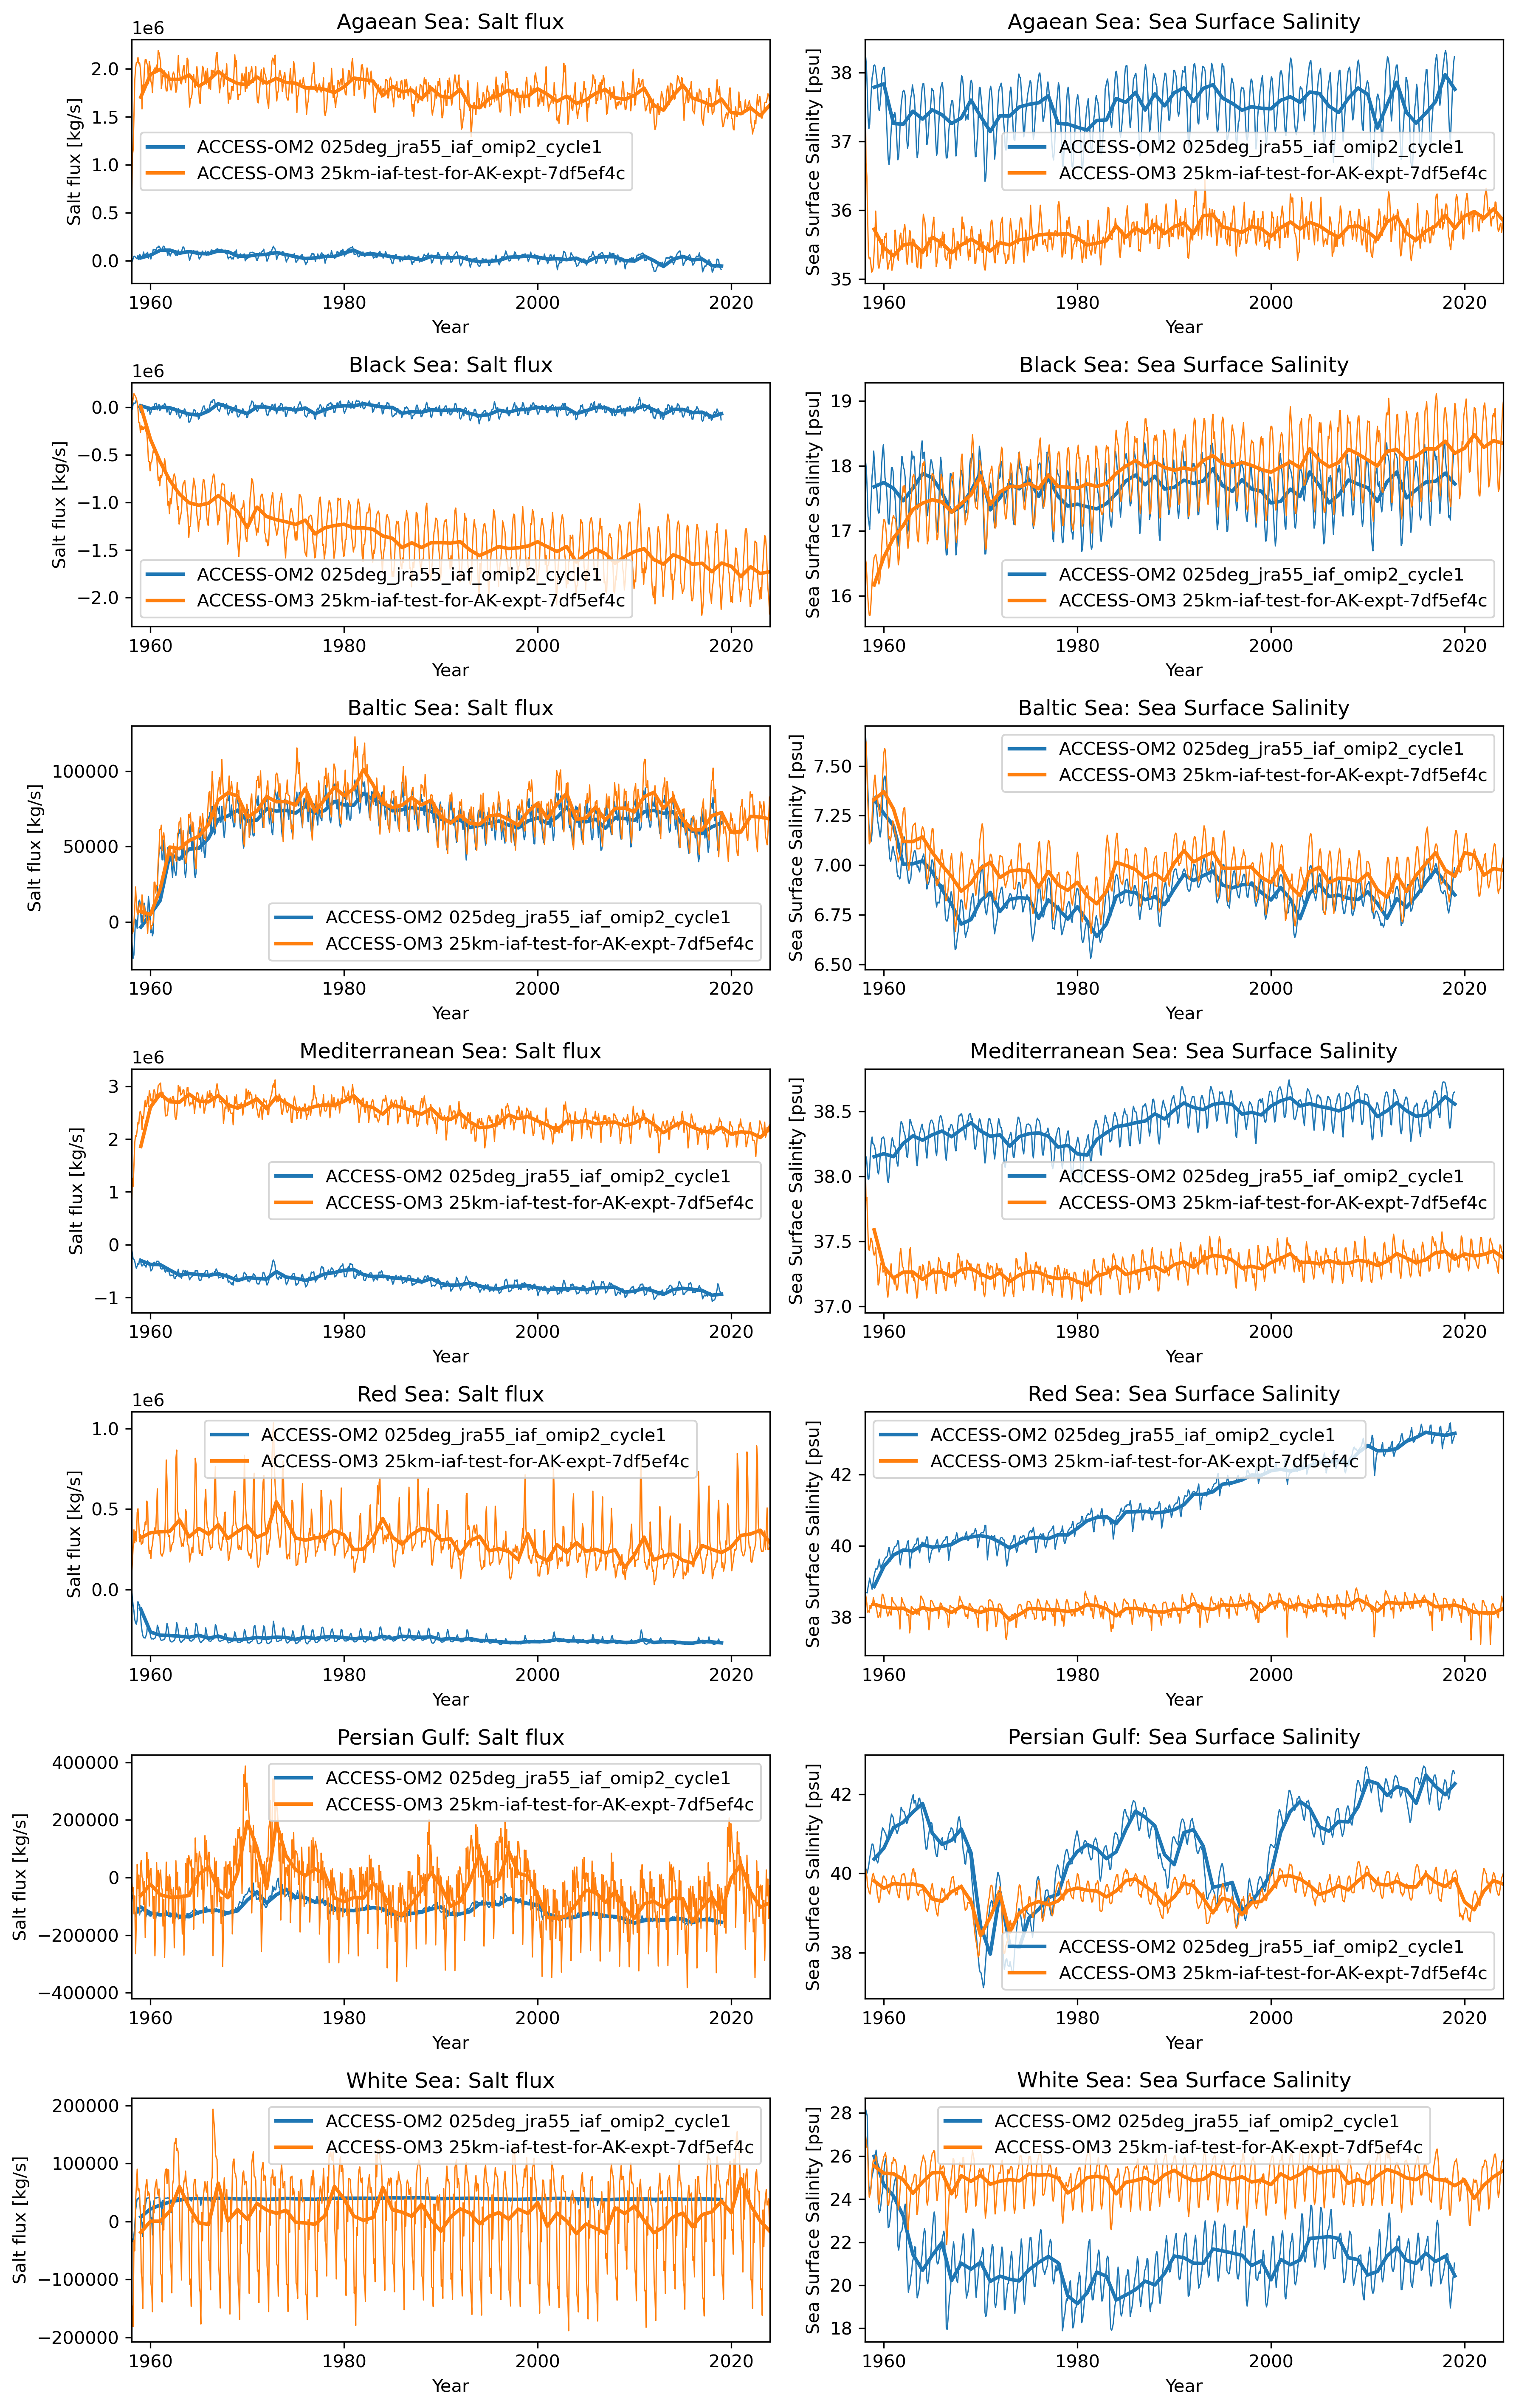

CPU times: user 2min 27s, sys: 1min 6s, total: 3min 33s
Wall time: 16min 4s


In [27]:
%%time
fig, axes = plt.subplots(
    nrows=len(regions), ncols=2, figsize=(12, 19))

for i, (region, bounds) in enumerate(regions.items()):
    salt_restore_OM3 = (
        salt_flux_scaled_om3
        .sel(xh=slice(bounds["lon1"], bounds["lon2"])).sum('xh', keep_attrs=True)
        .sel(yh=slice(bounds["lat1"], bounds["lat2"])).sum('yh', keep_attrs=True)
        .load()
    )
    salt_restore_OM2 = (
        salt_flux_scaled_om2
        .sel(xt_ocean=slice(bounds["lon1"], bounds["lon2"])).sum('xt_ocean', keep_attrs=True)
        .sel(yt_ocean=slice(bounds["lat1"], bounds["lat2"])).sum('yt_ocean', keep_attrs=True)
        .load()
    )

    salinity_OM3 = (
        surface_salt_om3
        .sel(xh=slice(bounds["lon1"], bounds["lon2"])).mean('xh', keep_attrs=True)
        .sel(yh=slice(bounds["lat1"], bounds["lat2"])).mean('yh', keep_attrs=True)
        .load()
    )
    salinity_OM2 = (
        surface_salt_om2
        .sel(xt_ocean=slice(bounds["lon1"], bounds["lon2"])).mean('xt_ocean', keep_attrs=True)
        .sel(yt_ocean=slice(bounds["lat1"], bounds["lat2"])).mean('yt_ocean', keep_attrs=True)
        .load()
    )

    ax1 = axes[i, 0]
    p = salt_restore_OM2.plot(ax=ax1, linewidth=.7)
    salt_restore_OM2.resample(time='1YE').mean('time').plot(
                ax=ax1,
                linewidth=2,
                color=p[-1].get_color(),
                label=f"ACCESS-OM2 {om2exptname}"
            )
    p = salt_restore_OM3.plot(ax=ax1, linewidth=.7)
    salt_restore_OM3.resample(time='1YE').mean('time').plot(
                ax=ax1,
                linewidth=2,
                color=p[-1].get_color(),
                label=f"ACCESS-OM3 {om3exptname}"
            )
    ax1.set_ylabel("Salt flux [kg/s]")
    ax1.set_title(f"{region}: Salt flux")
    ax1.set_xlabel("Year")
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax1.legend()

    ax2 = axes[i, 1]
    p = salinity_OM2.plot(ax=ax2, linewidth=.7)
    salinity_OM2.resample(time='1YE').mean('time').plot(
                ax=ax2,
                linewidth=2,
                color=p[-1].get_color(),
                label=f"ACCESS-OM2 {om2exptname}"
            )
    p = salinity_OM3.plot(ax=ax2, linewidth=.7)
    salinity_OM3.resample(time='1YE').mean('time').plot(
                ax=ax2,
                linewidth=2,
                color=p[-1].get_color(),
                label=f"ACCESS-OM3 {om3exptname}"
            )
    ax2.set_ylabel(f"{salinity_OM3.attrs['long_name']} [{salinity_OM3.attrs['units']}]")
    ax2.set_title(f"{region}: {salinity_OM3.attrs['long_name']}")
    ax2.set_xlabel("Year")
    ax2.autoscale(enable=True, axis='x', tight=True)
    ax2.legend()

plt.tight_layout()
# plt.savefig(f"{plotfolder}/Salinity_restoring_025_deg_all_regions.png", dpi=300)

if notebook_name!='not_using_mkfigs.sh': plt.savefig(plotfolder+'mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
if notebook_name!='not_using_mkfigs.sh': mkmd("Salinity Restoring","`"+notebook_name+"`: Timeseries of salinity restoring.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',plotfolder+'mkmd/')

plt.show()

### Maps

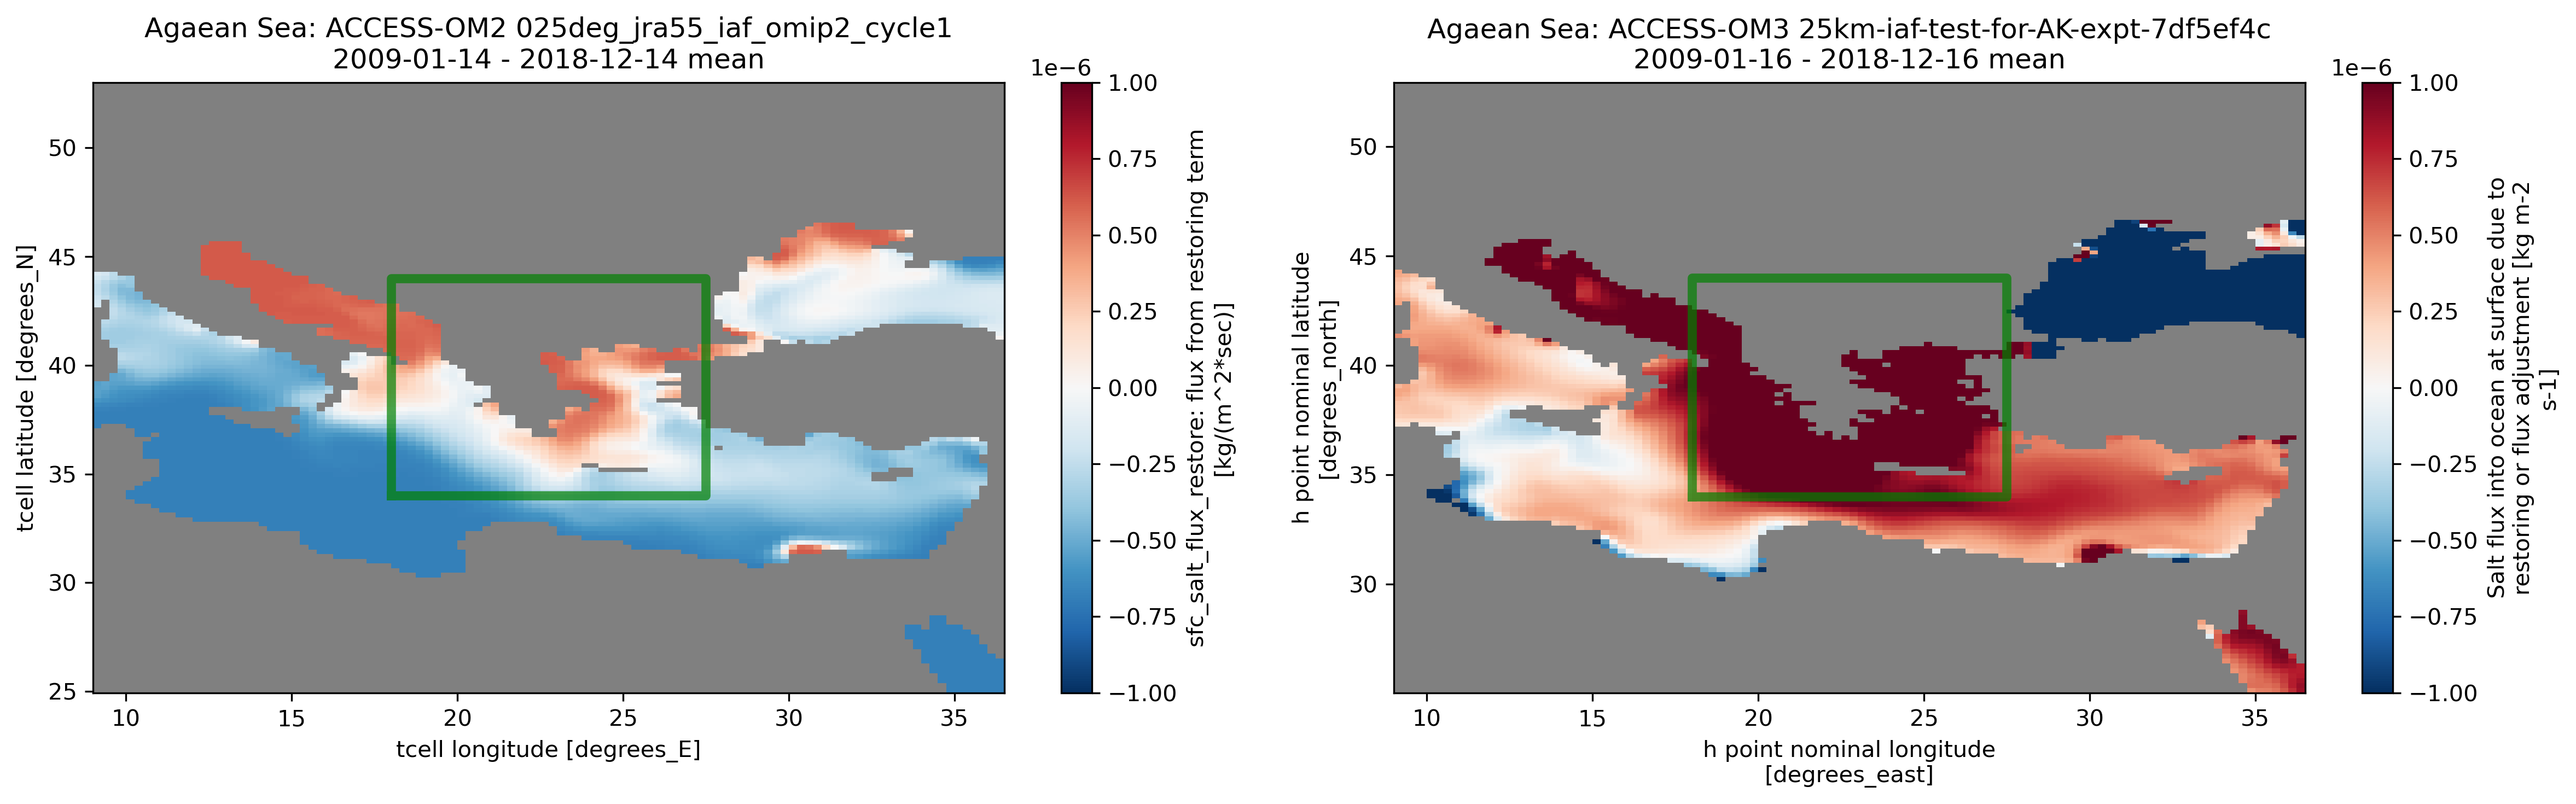

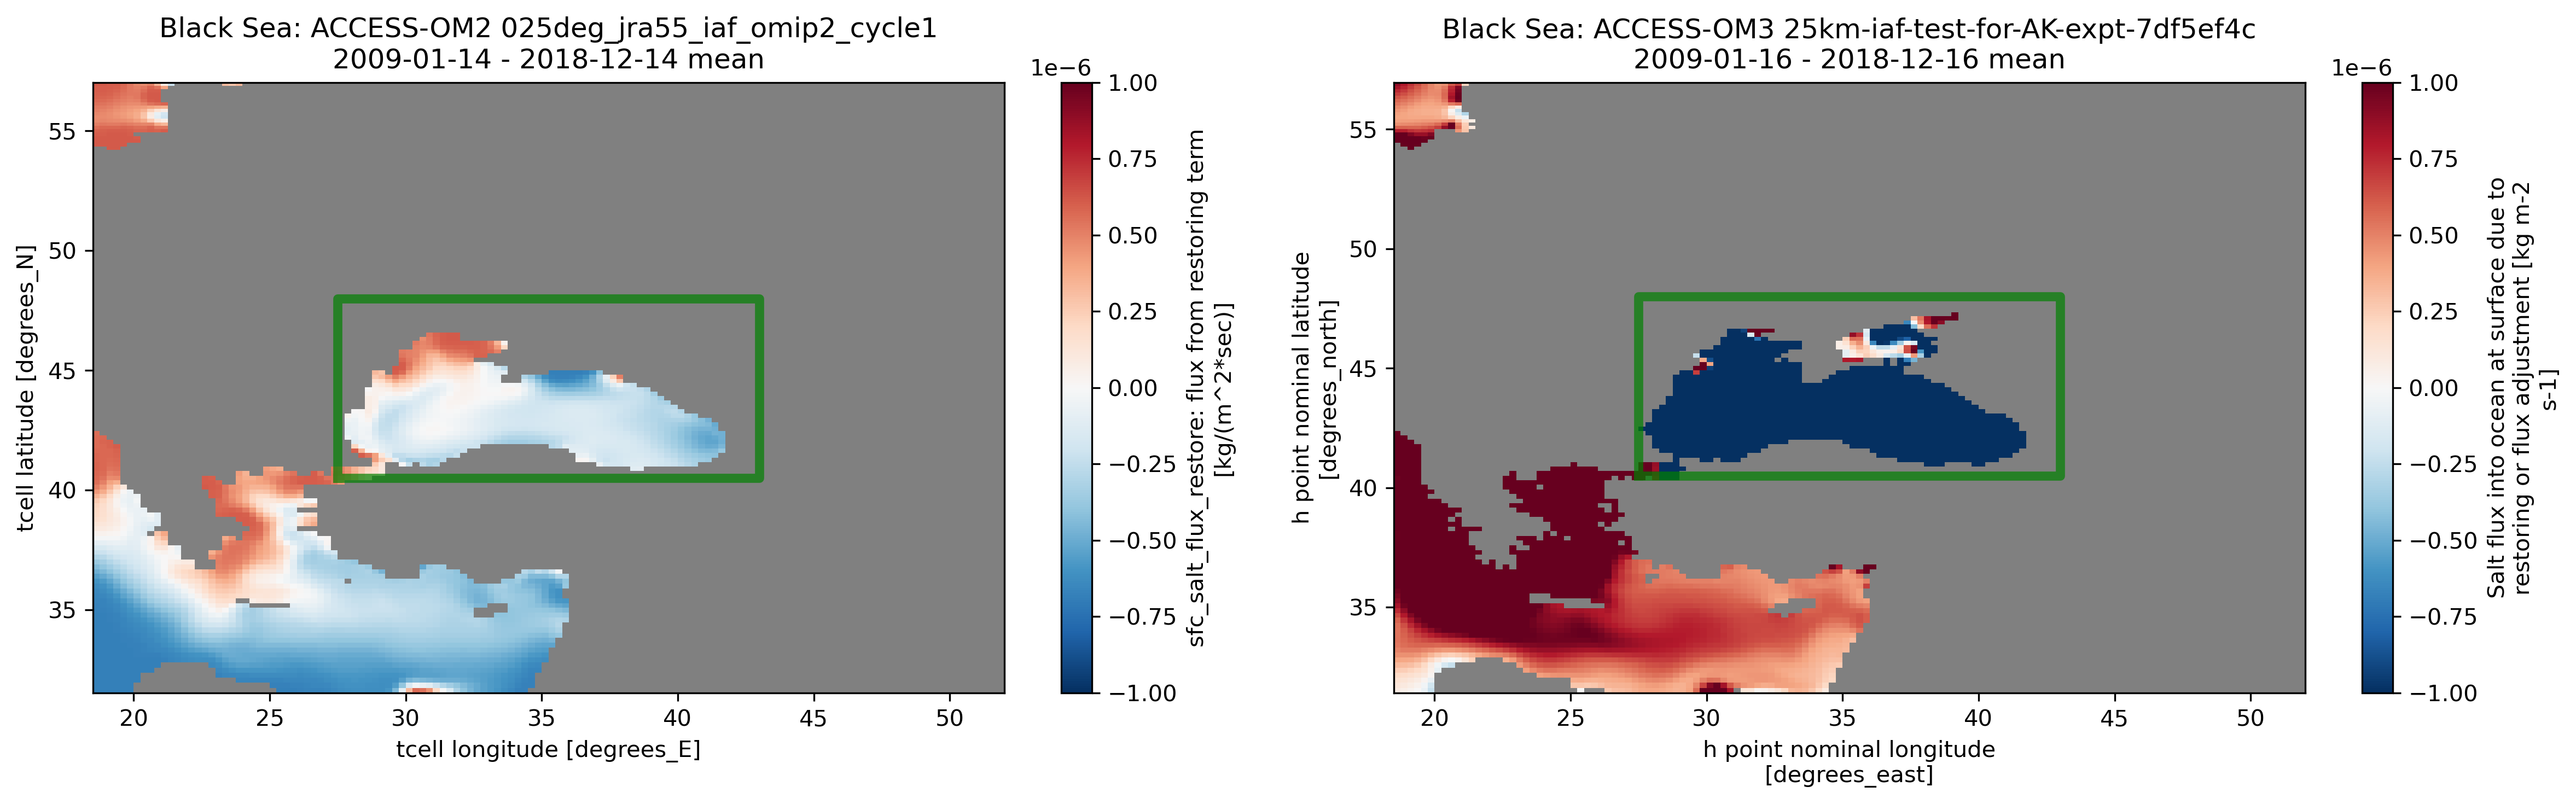

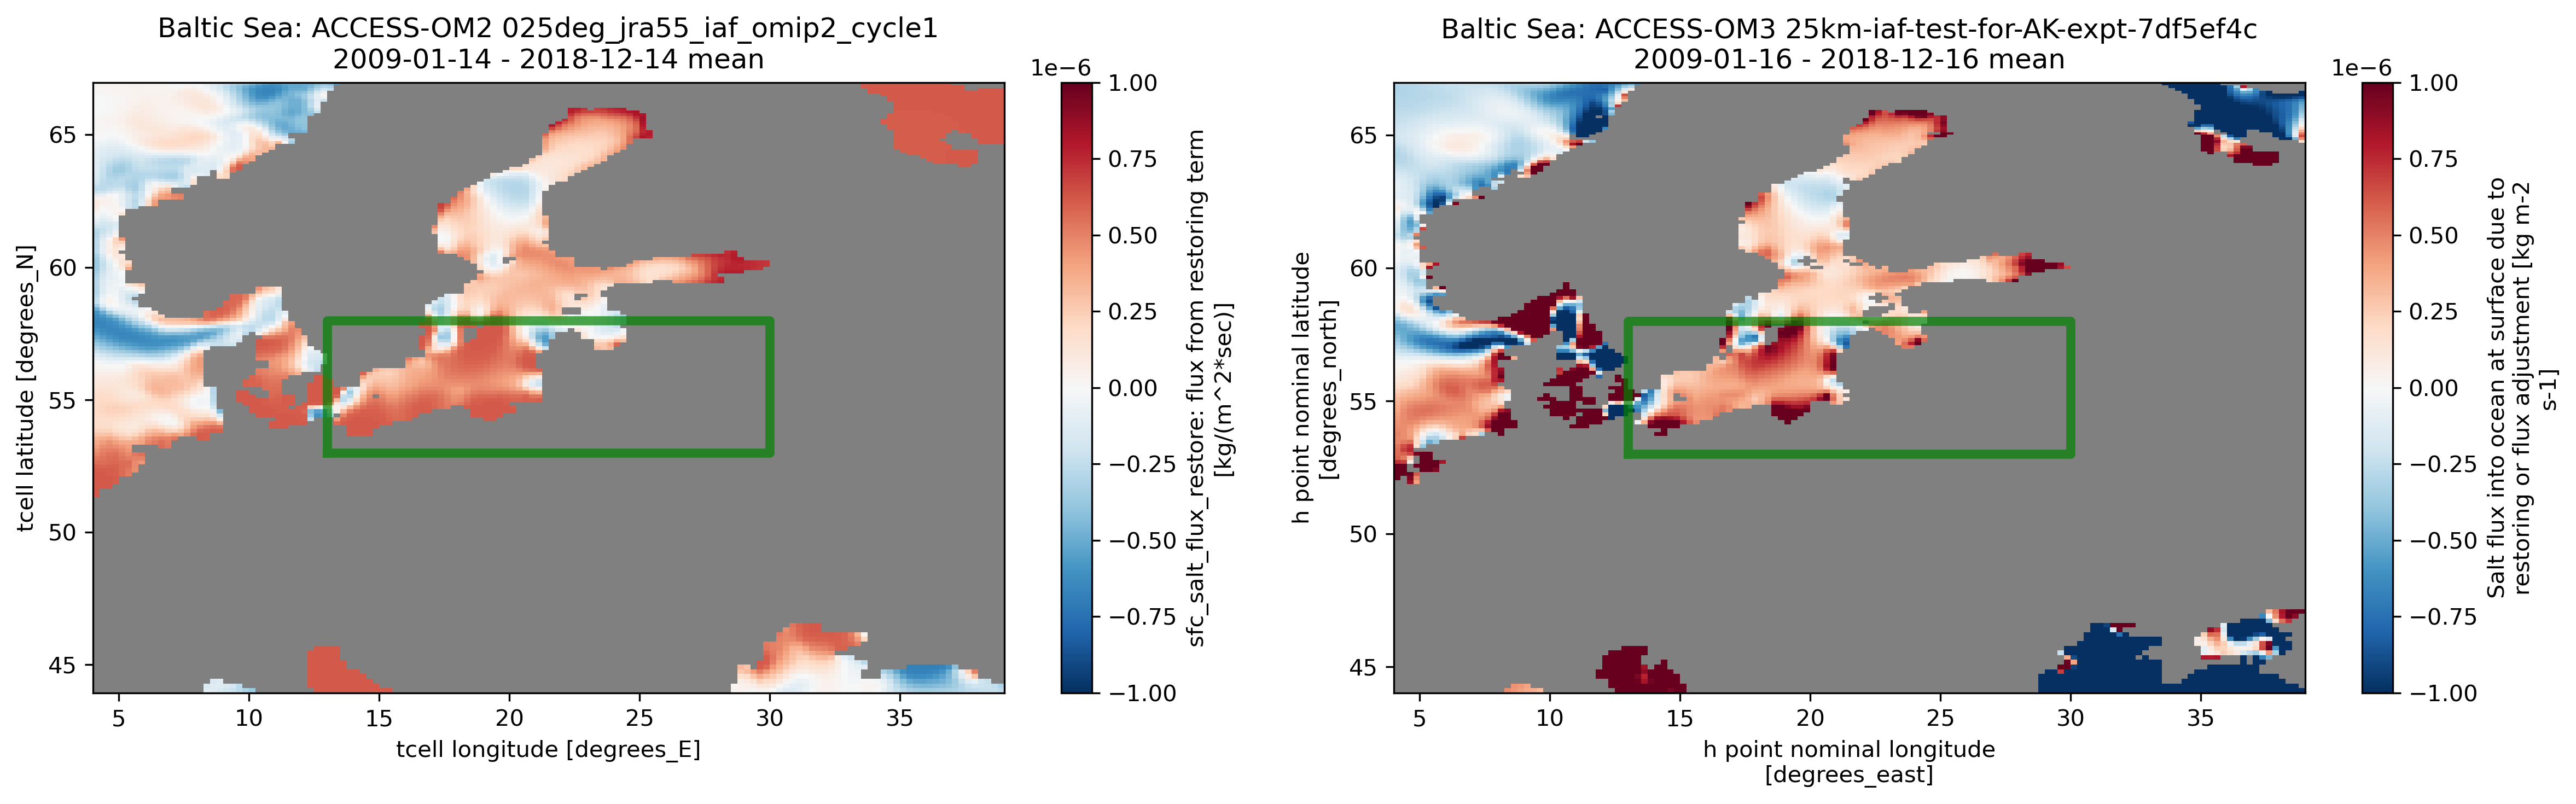

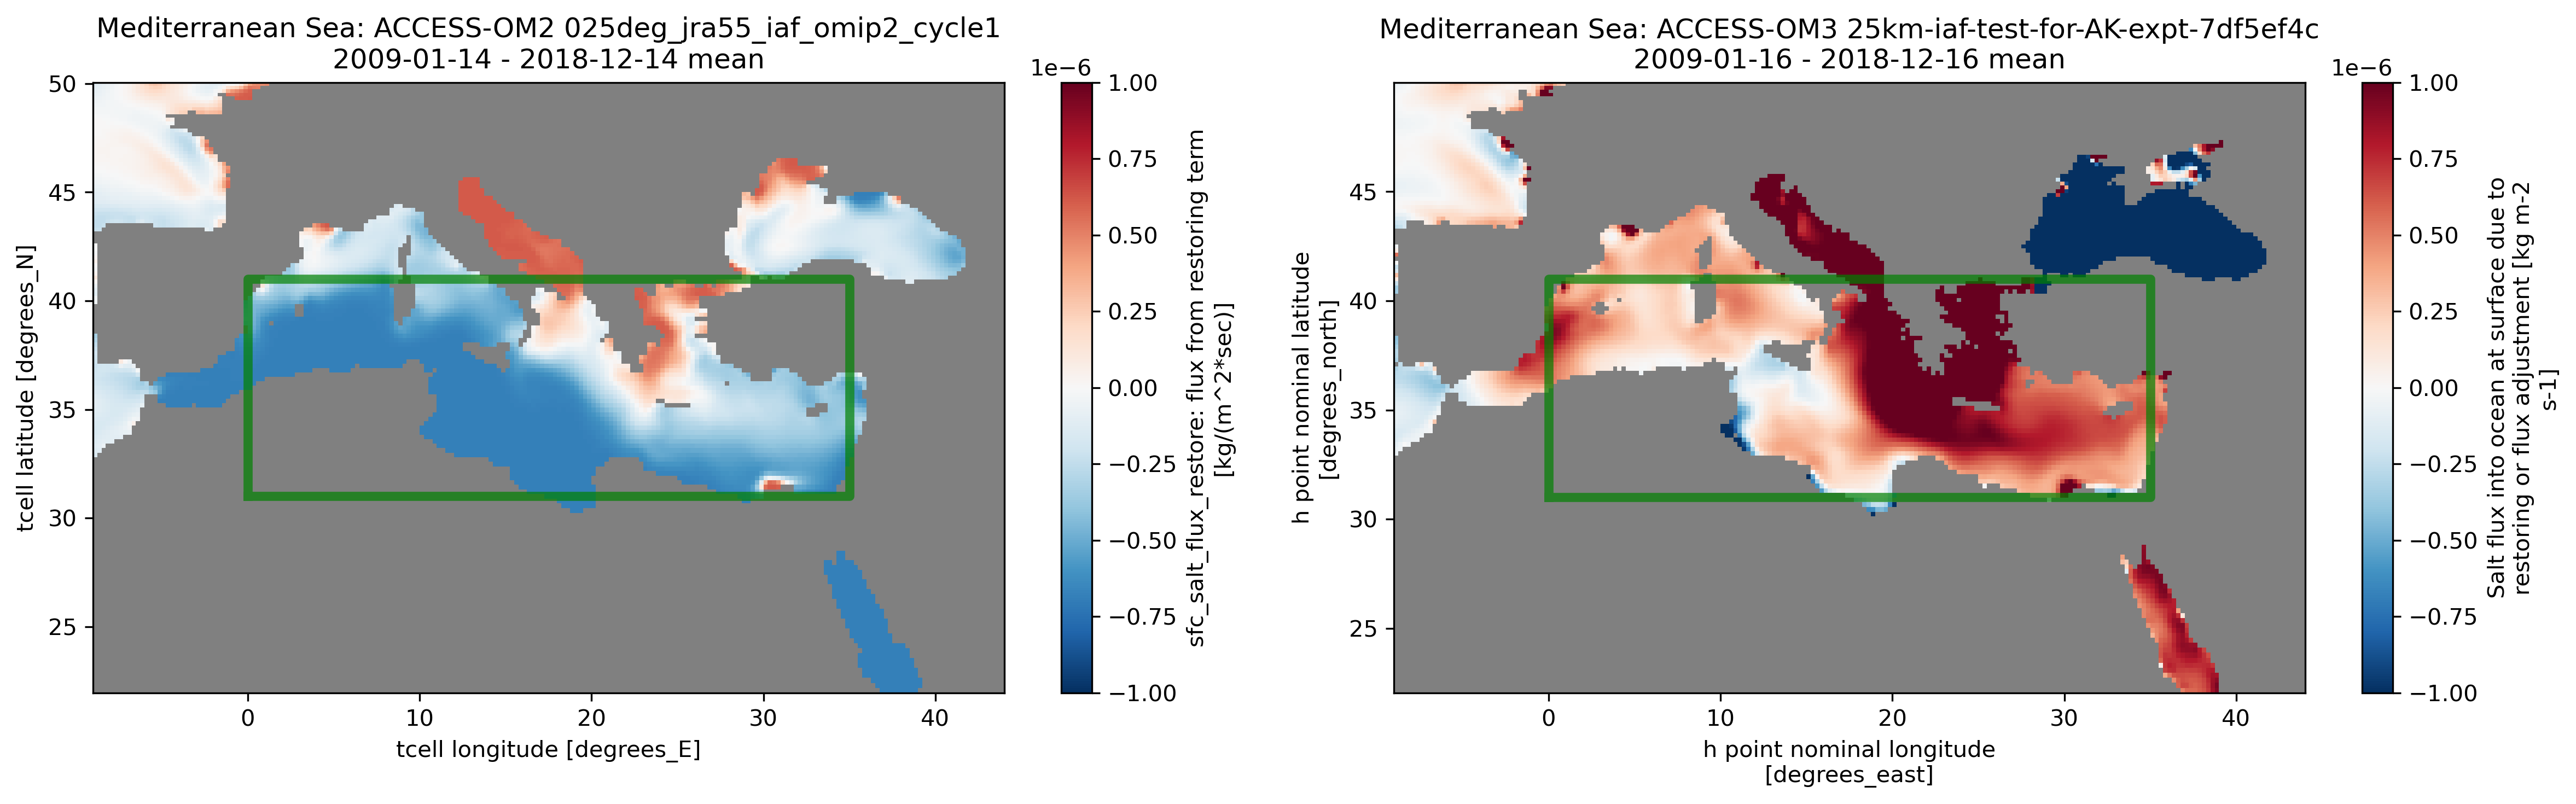

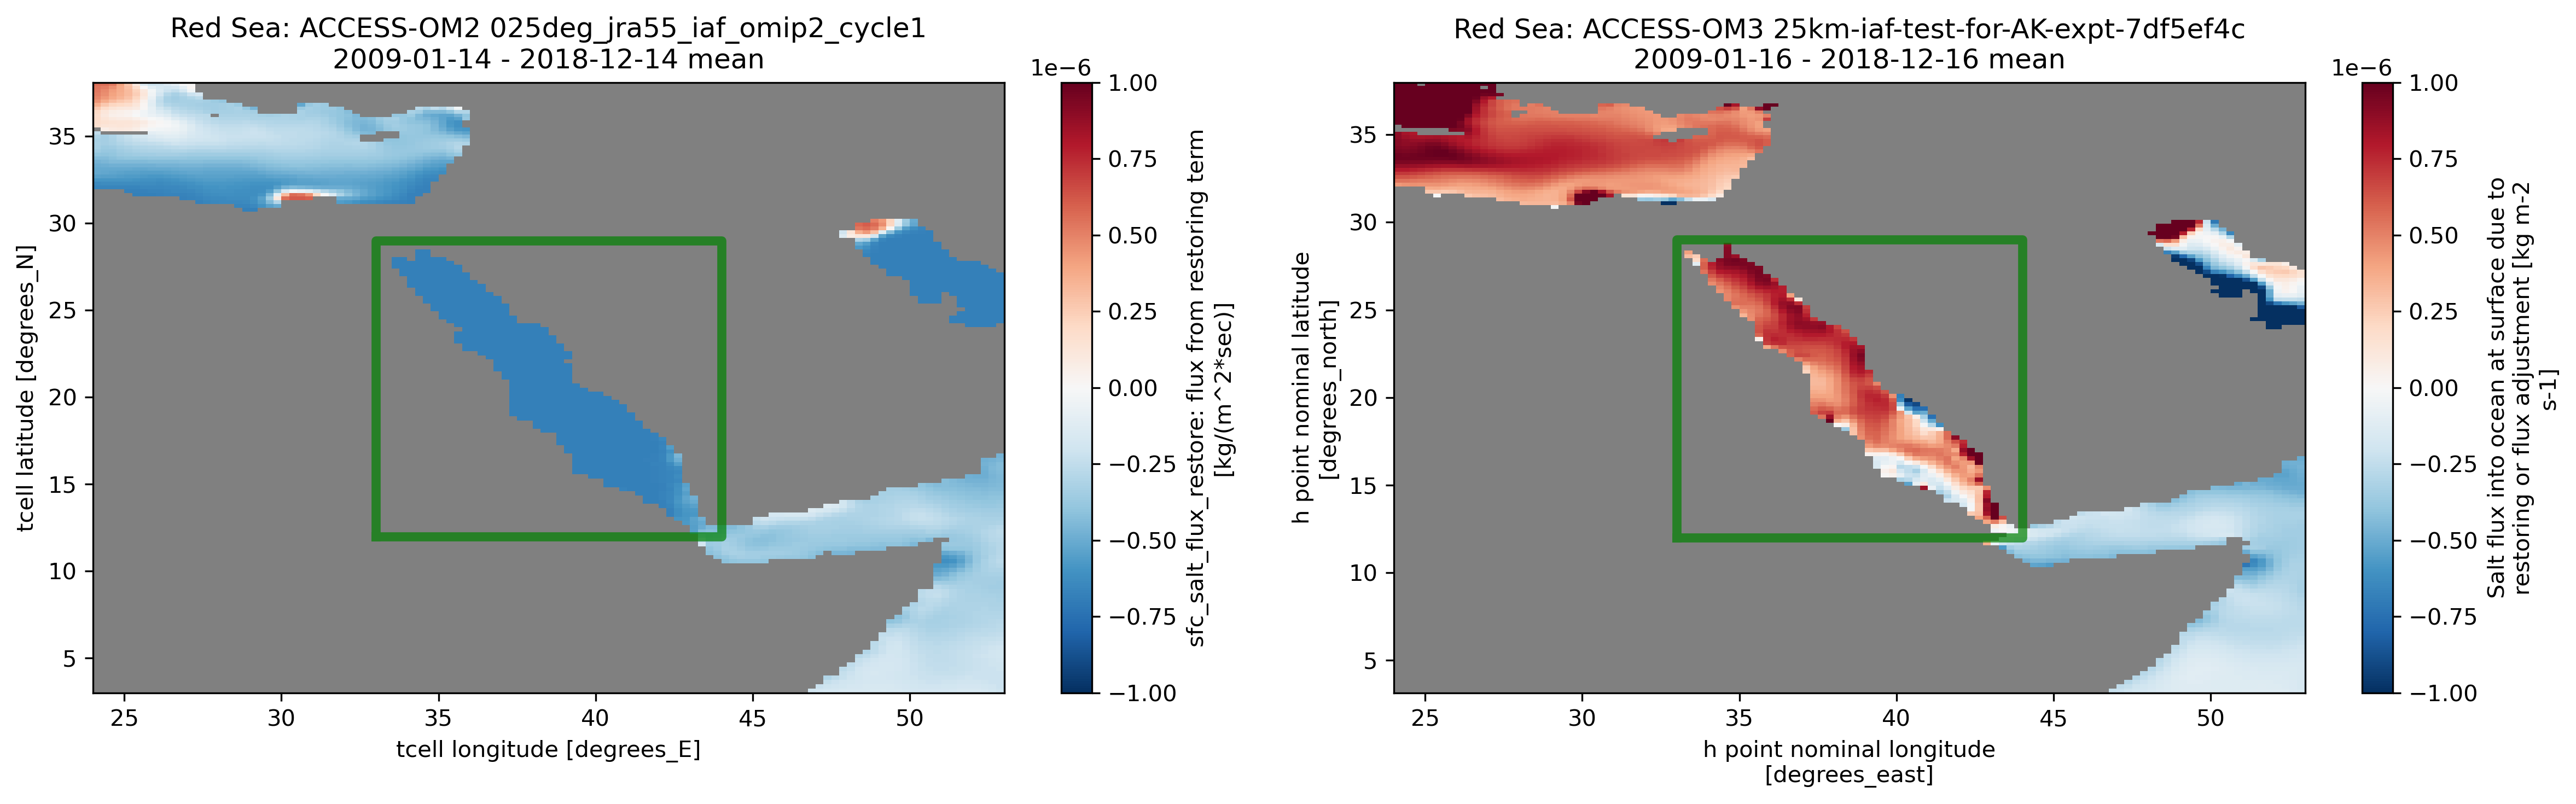

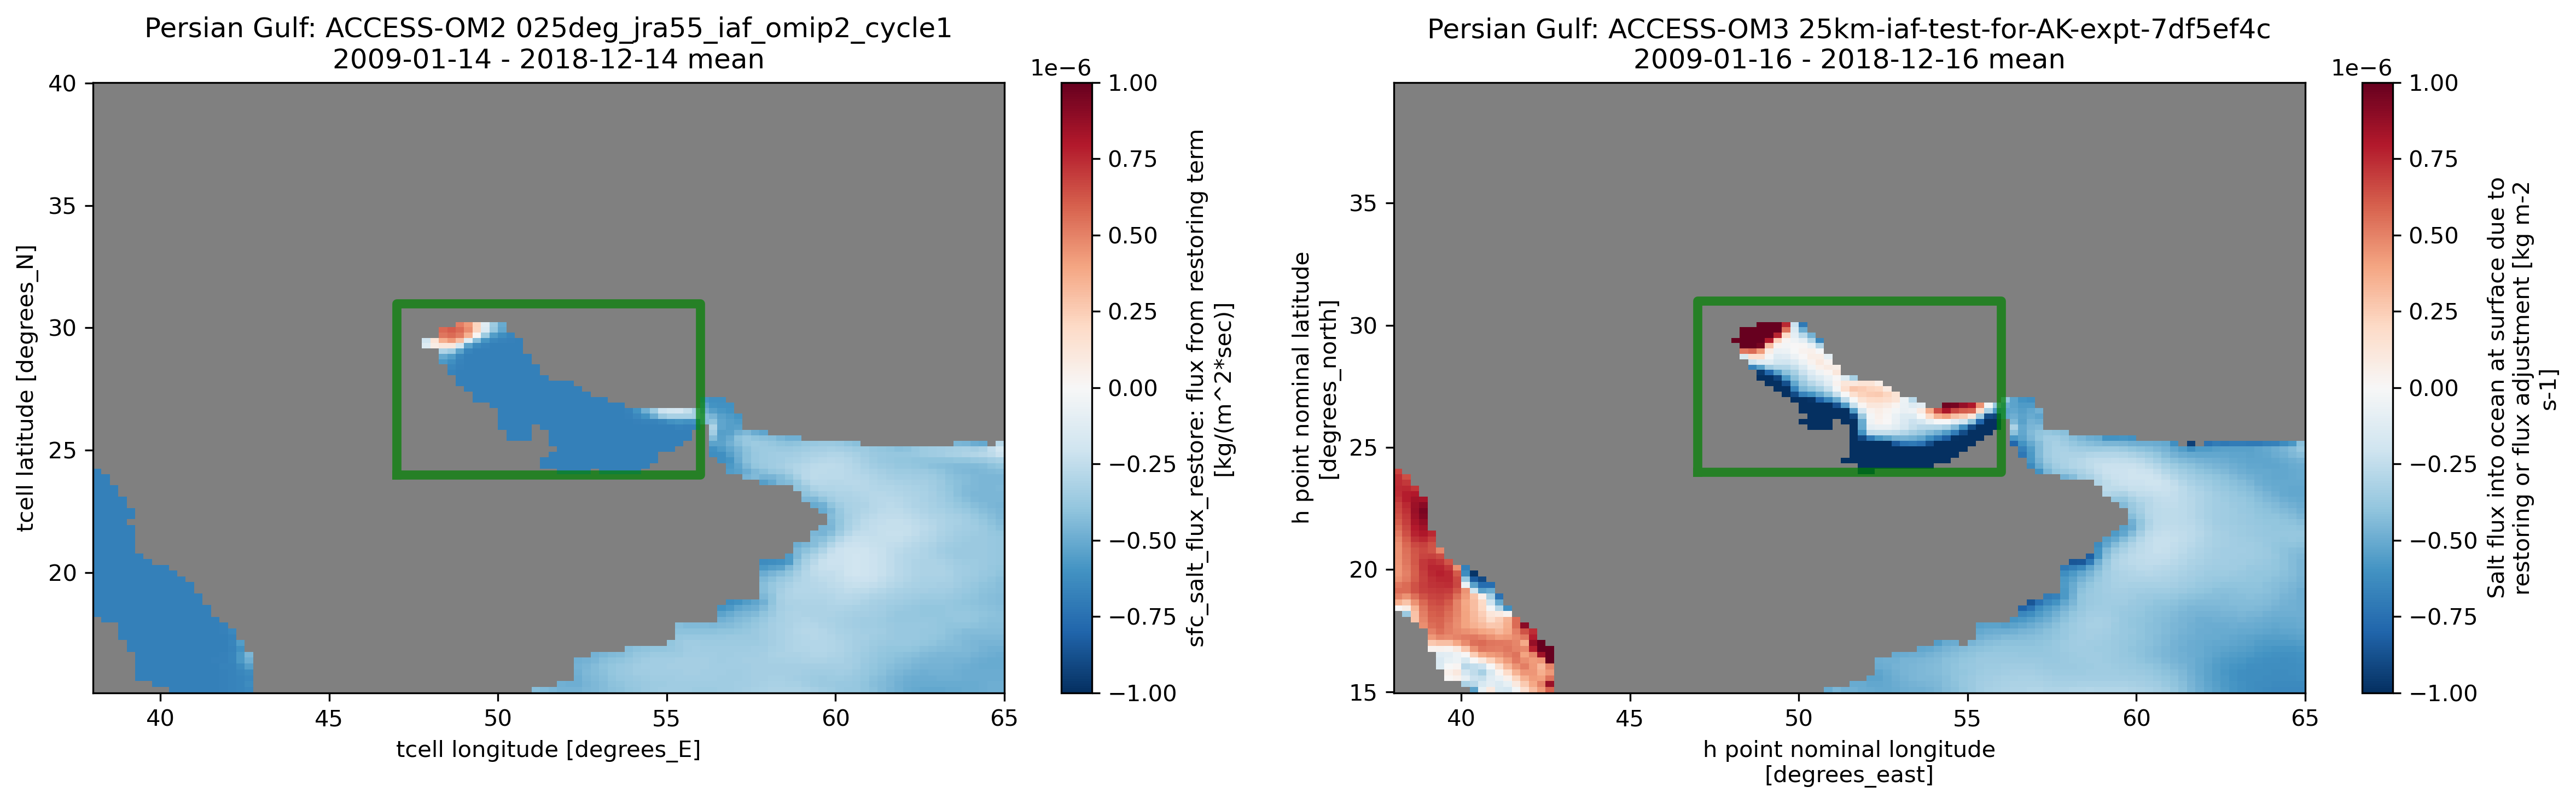

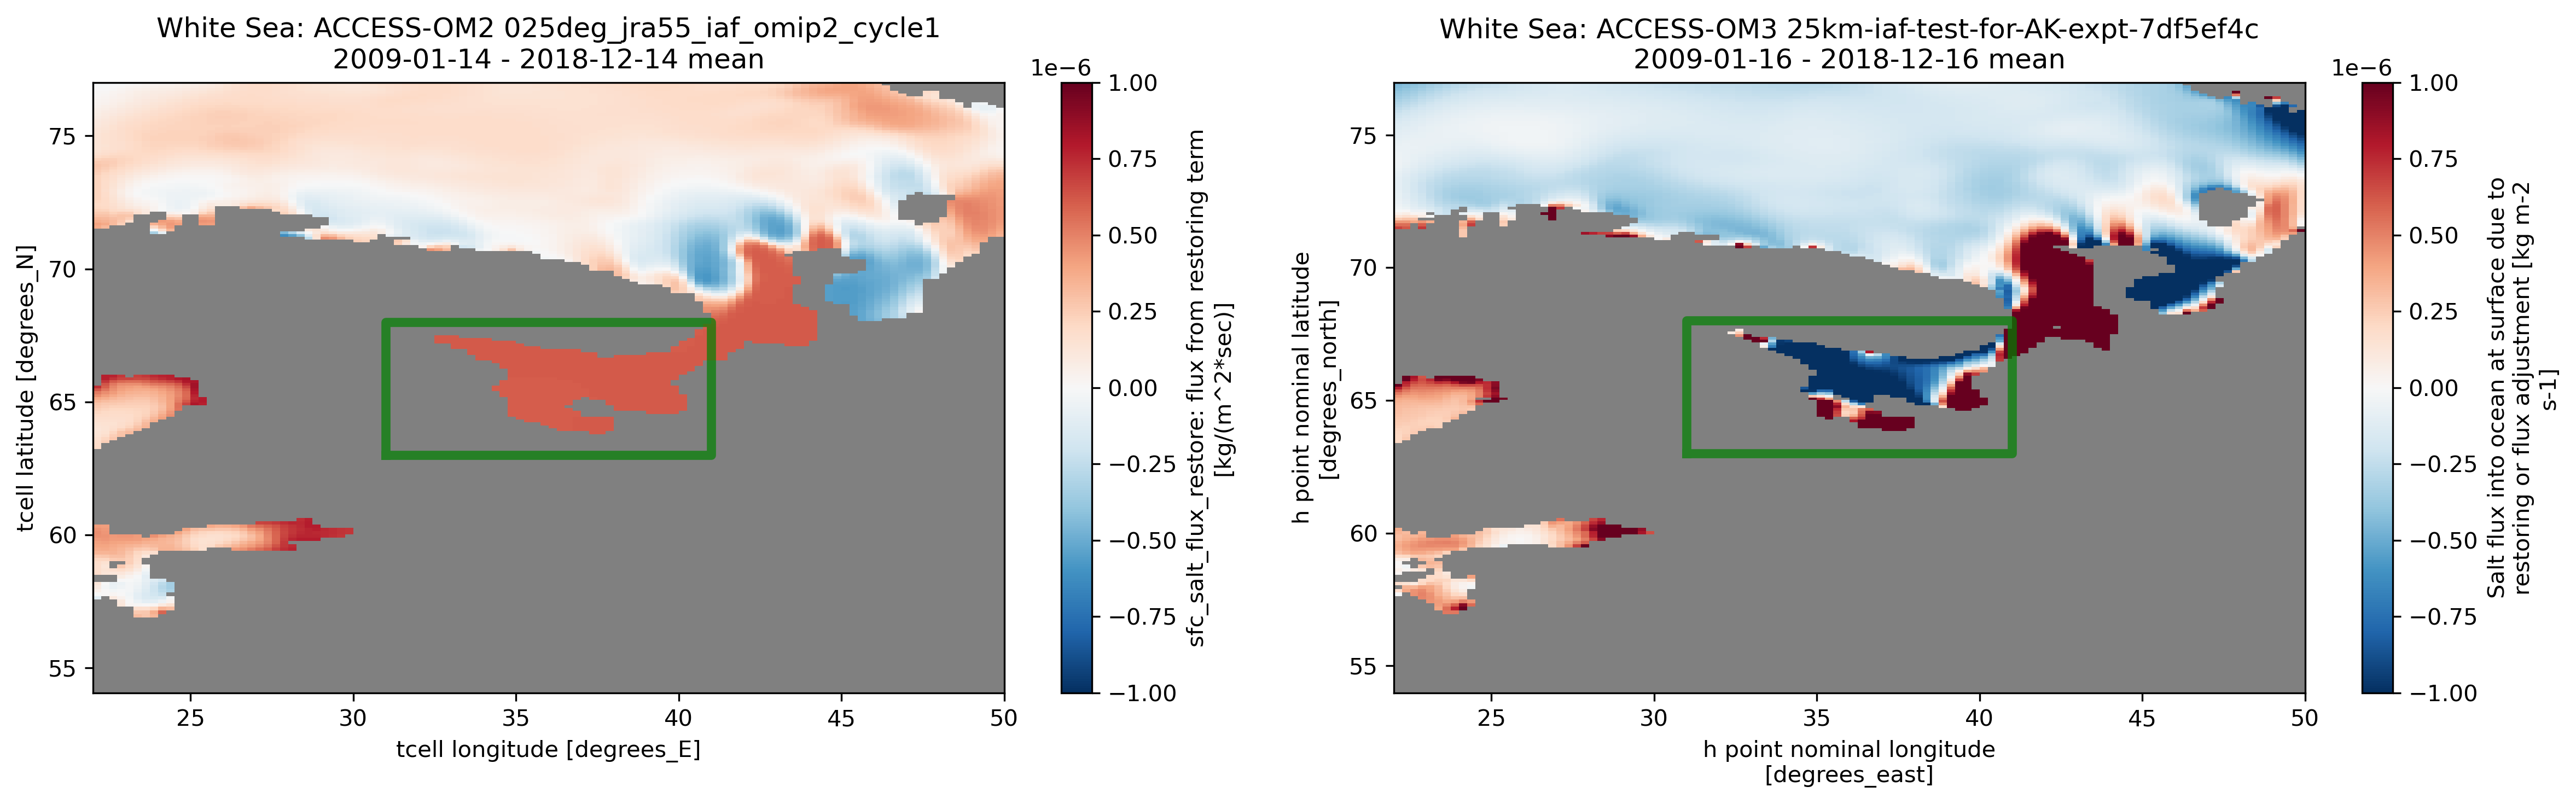

CPU times: user 12 s, sys: 1.61 s, total: 13.6 s
Wall time: 13.3 s


In [28]:
%%time
margin = 9
vmax = 1e-6
for region, bounds in regions.items():
    lon1 = bounds["lon1"]
    lon2 = bounds["lon2"]
    lat1 = bounds["lat1"]
    lat2 = bounds["lat2"]
    xslice = slice(lon1-margin, lon2+margin)
    yslice = slice(lat1-margin, lat2+margin)
    plt.figure(figsize=(16,5))

    # Right subplot (ACCESS-OM3)
    plt.subplot(122).set_facecolor('gray')  # gray land points
    data = salt_flux_added_om3.sel(xh=xslice).sel(yh=yslice).sel(time=timerange)
    p1 = data.mean('time').plot(vmax=vmax, add_colorbar=False)
    plt.plot([lon1, lon2, lon2, lon1, lon1],
             [lat1, lat1, lat2, lat2, lat1],
             color='green', linewidth=4, alpha=0.7)
    plt.title(f'{region}: ACCESS-OM3 {om3exptname}\n{data.time.values[0].strftime("%Y-%m-%d")} - {data.time.values[-1].strftime("%Y-%m-%d")} mean')
    cbar1 = plt.colorbar(p1, orientation="vertical")
    cbar1.set_label('\n'.join(textwrap.wrap(
        f"{salt_flux_added_om3.attrs['long_name']} [{salt_flux_added_om3.attrs['units']}]",
        width=40)))

    # Left subplot (ACCESS-OM2)
    plt.subplot(121).set_facecolor('gray')  # gray land points
    data = salt_flux_added_om2.sel(xt_ocean=xslice).sel(yt_ocean=yslice).sel(time=timerange)
    p2 = data.mean('time').plot(vmax=vmax, add_colorbar=False)
    plt.plot([lon1, lon2, lon2, lon1, lon1],
             [lat1, lat1, lat2, lat2, lat1],
             color='green', linewidth=4, alpha=0.7)
    plt.title(f'{region}: ACCESS-OM2 {om2exptname}\n{data.time.values[0].strftime("%Y-%m-%d")} - {data.time.values[-1].strftime("%Y-%m-%d")} mean')
    cbar2 = plt.colorbar(p2, orientation="vertical")
    cbar2.set_label('\n'.join(textwrap.wrap(
        f"{salt_flux_added_om2.attrs['long_name']} [{salt_flux_added_om2.attrs['units']}]",
        width=55)))
    
    plt.tight_layout()
    plt.show()